

In the production of electrical drives, a high product quality is needed. As the industry of electric drive production is confronted by trends such as electric mobility and continuing industrial automation, efficient and flexible processes are needed more than ever. With current quality monitoring technology, accurate quality checking is not feasible.

Electrical motors mainly consist of the rotor, the stator and the surrounding housing. The production process can be separated into multiple sub-processes, which can be seen below. The exact sequence of these steps however depends on the motor type. First, the individual components are manufactured and assembled into subassemblies such as the rotor and the stator. Finally, all components (the housing, the stator, the rotor as well as bearings and end shields) are assembled and the motor is checked in an end-of-line (EOL) test.

This final assembly is of great importance, as all parts need to be assembled in the correct way, to ensure smooth operation. Therefore, a quality monitoring system is needed, raising alarm if assembly errors are detected. However, especially in lot-size one production, traditional computer vision systems might reach their limits and cannot be used anymore.

Further background information can be found in this paper: [Mayr et al., Machine Learning in Electric Motor Production - Potentials, Challenges and Exemplary Applications](https://ieeexplore.ieee.org/document/9011861)

![Introduction](./img/Intro_dataset.png)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random


In [9]:
path = "./E_motor/top/L1_C_3.JPG"
img = cv2.imread(path)
img.shape

(1024, 1024, 3)

In [10]:
type(img)

numpy.ndarray

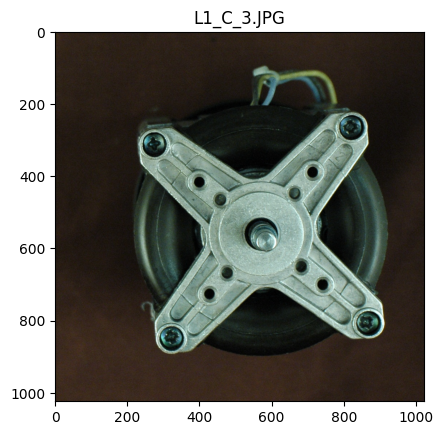

In [11]:
plt.title(path.split('/')[-1]) 
plt.imshow(img) 
plt.show()

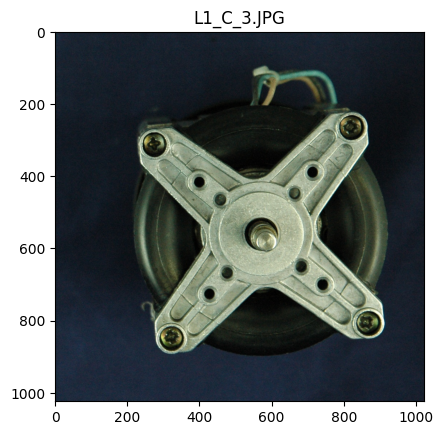

In [12]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
plt.title(path.split('/')[-1]) 
plt.imshow(img) # Display the imag
plt.show()

In [15]:
import glob

def get_label_from_name(path):
    if "_C_" in path:
        return "Complete"
    if "_MC_" in path:
        return "Missing cover"
    if "_MS_" in path:
        return "Missing screw"
    if "_NS_" in path:
        return "Not screwed"
    return "n/a" # TODO: Raise error

def load_features_labels(folder, size = (64,32), flatten = True, color = False, identifiers=['NS', 'MS', 'MC', 'C']):
    features, labels = [], [] 
   
    for file in glob.glob(folder + "/*.JPG"):
        if any(identifier in file for identifier in identifiers):
            
            img = cv2.imread(file)
            features.append(img)
            lab = get_label_from_name(file)
            labels.append(lab)


    return features, labels 

In [23]:
features, labels = load_features_labels("./E_motor/top")
print("Number of features:", len(features))
print("Number of labels:", len(labels))

Number of features: 117
Number of labels: 117


In [18]:
def image_preprocessing(img, size = (64,32), flatten = True, color = False):
    img = cv2.resize(img, size)
    if not color:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if flatten:
        img = img.reshape(-1)
    return img

In [20]:
def load_features_labels(folder, size = (64,32), flatten = True, color = False, identifiers=['NS', 'MS', 'MC', 'C']):
    features, labels = [], [] 
    for file in glob.glob(folder + "/*.JPG"):
        if any(identifier in file for identifier in identifiers):
            
            img = cv2.imread(file)
            preimg = image_preprocessing(img, size, flatten, color)
            features.append(preimg)
            lab = get_label_from_name(file)
            labels.append(lab)

    return features, labels # Return results

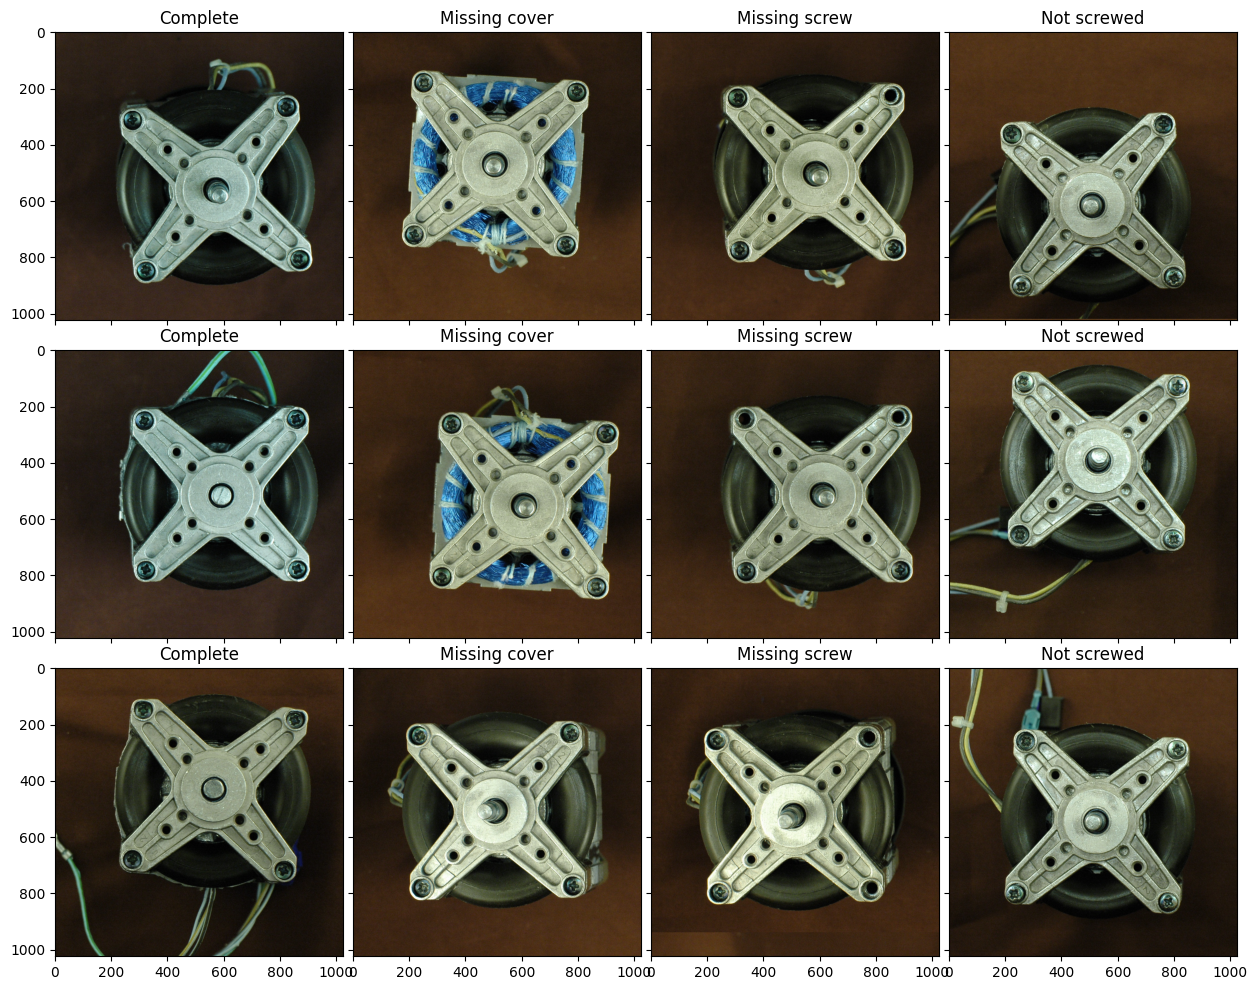

In [24]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3))

features, labels = load_features_labels("./E_motor/top", size=(1024, 1024), flatten=False, color=True)
classes = ['Complete', 'Missing cover', 'Missing screw', 'Not screwed']
for i, ax in enumerate(grid):
    selectedClass = classes[i%4] 
    images = np.array(features)[np.array(labels)==selectedClass] 
    image = images[i//4] 
    ax.imshow(image) 
    ax.set_title(selectedClass) 
plt.show()

In [25]:
from collections import Counter
print(Counter(labels))

Counter({'Not screwed': 47, 'Missing screw': 42, 'Missing cover': 22, 'Complete': 6})


Text(0, 0.5, 'Total quantity')

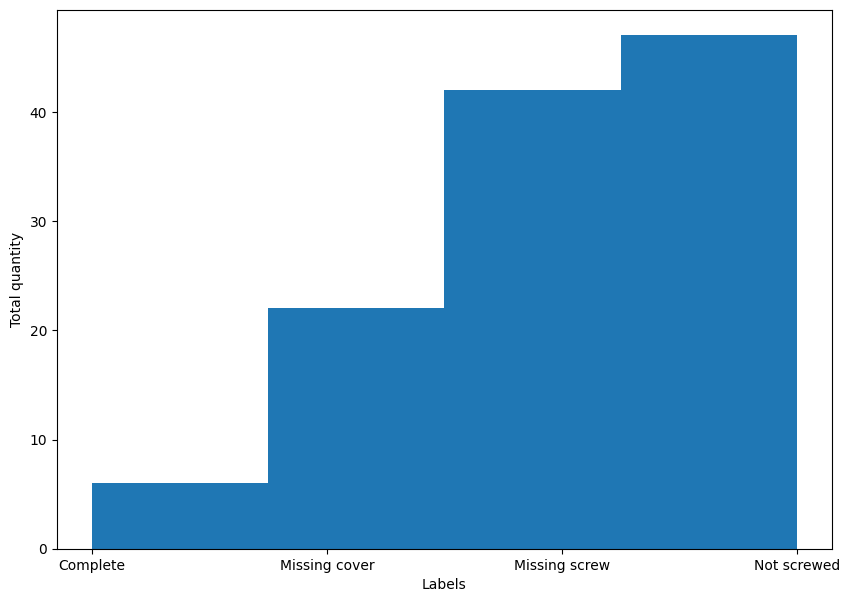

In [26]:
#############################
%matplotlib inline
plt.figure(figsize=(10,7))
plt.hist(labels, bins = 4)
plt.xlabel('Labels')
plt.ylabel('Total quantity')
#############################



In [31]:
features, labels = load_features_labels("./E_motor/top", size=(16,16), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 768)
Shape label vector: (70,)


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, train_size=0.7, random_state=42, stratify=labels)



In [33]:
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
clf = SVC(kernel="rbf", gamma=0.01, C=0.0003) # Initialize the SVM
clf.fit(X_train, y_train, sample_weight=compute_sample_weight('balanced', y_train)) # Train the SVM
print("Score:", clf.score(X_test, y_test)) # Test the model

Score: 0.6190476190476191


c:\Users\badar\miniconda3\envs\experiences\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\badar\miniconda3\envs\experiences\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\badar\miniconda3\envs\experiences\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.00      0.00      0.00         6
Missing screw       0.62      1.00      0.76        13

     accuracy                           0.62        21
    macro avg       0.21      0.33      0.25        21
 weighted avg       0.38      0.62      0.47        21



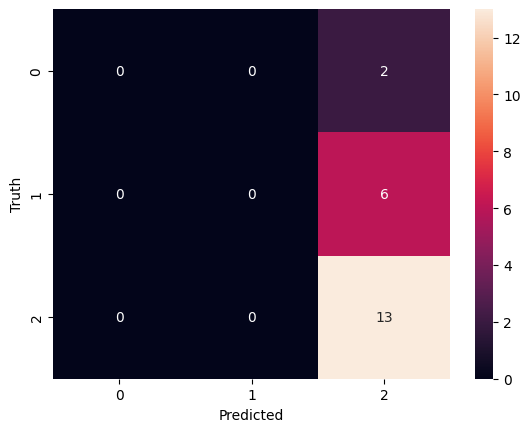

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, clf.predict(X_test))
ax=sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, clf.predict(X_test)))

In [37]:
features, labels = load_features_labels("./E_motor/top", size=(128,128), color=True, flatten=True, identifiers=['MC', 'MS', 'C'])
features = np.asarray(features)
labels = np.asarray(labels)
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 49152)
Shape label vector: (70,)


In [38]:

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, train_size=0.7, random_state=42, stratify=labels)


In [41]:
from sklearn.preprocessing import OneHotEncoder
print("Label of first sample before OneHot encoding:", y_train[0])
enc = OneHotEncoder(sparse_output=False) 
y_train = enc.fit_transform(y_train.reshape(-1, 1))
print("Label of first sample after OneHot encoding:", y_train[0])
y_test = enc.transform(y_test.reshape(-1, 1))

Label of first sample before OneHot encoding: Missing cover
Label of first sample after OneHot encoding: [0. 1. 0.]


In [45]:
from keras import Sequential
from keras import layers

model = Sequential()
model.add(layers.Dense(32, input_shape = X_train[0].shape))
model.add(layers.Activation("relu"))
model.add(layers.Dense(16))
model.add(layers.Activation("relu"))
model.add(layers.Dense(y_train[0].shape[0]))
model.add(layers.Activation("softmax"))

print(model.summary())

c:\Users\badar\miniconda3\envs\experiences\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │     1,572,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,573,475 (6.00 MB)

 Trainable params: 1,573,475 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

None


In [46]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

Now, the model can be trained using the datasets defined before.

In [47]:
model.fit(X_train, y_train, epochs = 20, batch_size = 8, validation_split=0.2, verbose = 1)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.3235 - loss: 828.1928 - val_accuracy: 0.4000 - val_loss: 841.1935
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3659 - loss: 811.1895 - val_accuracy: 0.6000 - val_loss: 276.6557
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5369 - loss: 364.3580 - val_accuracy: 0.6000 - val_loss: 304.2071
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5198 - loss: 192.4579 - val_accuracy: 0.4000 - val_loss: 97.0223
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6665 - loss: 81.7420 - val_accuracy: 0.6000 - val_loss: 69.4981
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7913 - loss: 40.8070 - val_accuracy: 0.4000 - val_loss: 104.0028
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.5901 - loss: 43.9775 - val_accuracy: 0.6000 - val_loss: 108.8492
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8961 - loss: 8.1351 - val_accuracy: 0

You can use the following function to evaluate your model.

In [49]:
def evaluate_model(X_test, y_test, model):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix, classification_report

    y_pred = model.predict(X_test)
    res = np.zeros_like(y_pred)
    for i in range(len(np.argmax(y_pred, axis=1))):
        res[i, np.argmax(y_pred,axis=1)[i]]=1
    y_pred = res
    cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
    ax=sns.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    print(classification_report(enc.inverse_transform(y_test), enc.inverse_transform(y_pred), zero_division=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.33      0.17      0.22         6
Missing screw       0.61      0.85      0.71        13

     accuracy                           0.57        21
    macro avg       0.31      0.34      0.31        21
 weighted avg       0.47      0.57      0.50        21



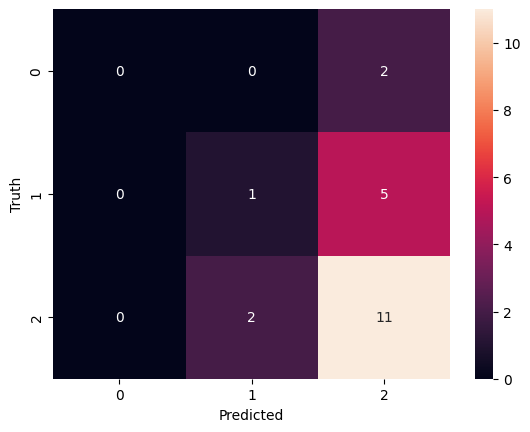

In [50]:
evaluate_model(X_test, y_test, model)

In [53]:
features, labels = load_features_labels("./E_motor/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) 
labels = np.array(labels) 
print("Shape feature vector:", features.shape)
print("Shape label vector:", labels.shape)

Shape feature vector: (70, 512, 512, 3)
Shape label vector: (70,)


In [88]:


def split_data(features, labels):
    return train_test_split(features, labels, test_size=0.3, train_size=0.7, random_state = 42, stratify=labels)

def encode_data(y_train, y_test):
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(sparse_output=False)
    y_train = enc.fit_transform(y_train.reshape(-1, 1))
    y_test = enc.transform(y_test.reshape(-1, 1))
    return y_train, y_test
X_train, X_test, y_train, y_test = split_data(features, labels)
print("Label of first sample after OneHot encoding:", y_train[0])


Label of first sample after OneHot encoding: Missing cover


In [89]:
#Troubleshooting
print("Shape X_train = ", X_train[0].shape)
print("Shape y_train = ", y_train.shape)
print("Shape y_test = ", y_test.shape),
print("ndim X_train = ", X_train[0].ndim)

Shape X_train =  (512, 512, 3)
Shape y_train =  (49,)
Shape y_test =  (21,)
ndim X_train =  3


In [90]:
from keras import Sequential
from keras import layers

model = Sequential()
model.add(layers.Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, activation = 'relu', padding="same"))
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(X_train[0].ndim, activation = 'softmax'))

print(model.summary())

c:\Users\badar\miniconda3\envs\experiences\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 512, 512, 8)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 256, 256, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 256, 256, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_8          │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,571 (29.57 KB)

 Trainable params: 7,571 (29.57 KB)

 Non-trainable params: 0 (0.00 B)

None


In [91]:
from keras import optimizers
optimizer=optimizers.Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
print(y_train)
y_train,y_test= encode_data(y_train, y_test)
print(y_test)

['Missing cover' 'Missing screw' 'Missing cover' 'Missing screw'
 'Missing screw' 'Complete' 'Complete' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing cover' 'Missing screw' 'Missing screw' 'Missing screw'
 'Complete' 'Missing screw' 'Missing cover' 'Missing cover'
 'Missing cover' 'Missing screw' 'Missing cover' 'Missing screw'
 'Missing screw' 'Missing cover' 'Missing cover' 'Missing screw'
 'Complete' 'Missing cover' 'Missing screw' 'Missing screw'
 'Missing screw' 'Missing screw' 'Missing screw' 'Missing cover'
 'Missing cover' 'Missing screw' 'Missing screw' 'Missing screw'
 'Missing cover' 'Missing cover' 'Missing screw' 'Missing cover'
 'Missing screw' 'Missing cover' 'Missing screw' 'Missing screw']
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0.

In [92]:
model.fit(np.array(X_train), np.array(y_train), epochs = 75, batch_size = 32, validation_split=0.1,verbose=1, sample_weight=compute_sample_weight('balanced', y_train))

Epoch 1/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.2093 - loss: 18.2280 - val_accuracy: 0.0000e+00 - val_loss: 11.4655
Epoch 2/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 829ms/step - accuracy: 0.2036 - loss: 10.1504 - val_accuracy: 0.4000 - val_loss: 3.9632
Epoch 3/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3163 - loss: 10.4401 - val_accuracy: 0.2000 - val_loss: 0.8073
Epoch 4/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 731ms/step - accuracy: 0.2036 - loss: 6.2297 - val_accuracy: 0.2000 - val_loss: 1.4019
Epoch 5/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 575ms/step - accuracy: 0.2301 - loss: 3.5446 - val_accuracy: 0.0000e+00 - val_loss: 4.0802
Epoch 6/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 806ms/step - accuracy: 0.1430 - loss: 3.5776 - val_accuracy: 0.0000e+00 - val_loss: 3.0251
Epoch 7/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 698ms/step - accuracy: 0.1790 - loss: 2.4402 - val_accuracy: 0.4000 - val_loss: 1.0661
Epoch 8/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 619ms/step - accuracy: 0.5710 - loss: 0.9830 - val_accuracy: 0.6000 -

Evaluate the trained CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.75      1.00      0.86         6
Missing screw       0.78      0.54      0.64        13

     accuracy                           0.62        21
    macro avg       0.51      0.51      0.50        21
 weighted avg       0.70      0.62      0.64        21



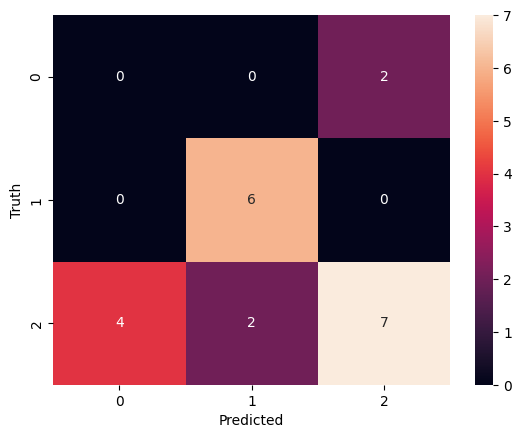

In [93]:
evaluate_model(X_test, y_test, model)

c:\Users\badar\miniconda3\envs\experiences\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.3253 - loss: 30.5198 - val_accuracy: 0.2000 - val_loss: 1.6302
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.3506 - loss: 16.8489 - val_accuracy: 0.4000 - val_loss: 2.8904
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.4938 - loss: 20.4530 - val_accuracy: 0.6000 - val_loss: 0.7765
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.4730 - loss: 8.5953 - val_accuracy: 0.8000 - val_loss: 0.4428
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.3514 - loss: 11.8579 - val_accuracy: 0.8000 - val_loss: 0.2079
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.3990 - loss: 6.4400 - val_accuracy: 0.6000 - val_loss: 0.2730
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.3944 - loss: 3.6468 - val_accuracy: 0.8000 - val_loss: 0.1817
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.4085 - loss: 4.9875 - val_accuracy: 0.600

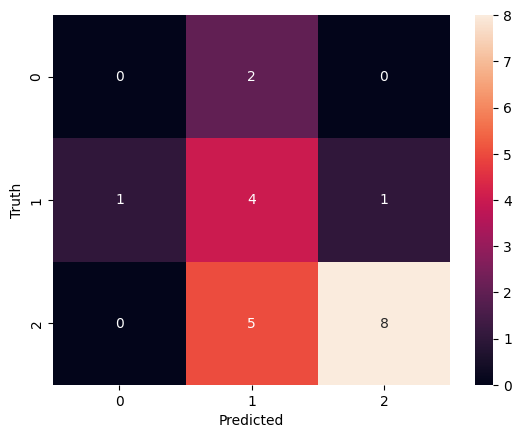

In [99]:
np.random.seed(28)
from keras import Sequential
from keras import layers
from keras import optimizers
# Data preprocessing
features, labels = load_features_labels("./E_motor/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
X_train, X_test, y_train, y_test = split_data(features, labels) # Split features and labels into training and testing datasets
y_train, y_test = encode_data(y_train, y_test) # Encode labels

# Model definition
model = Sequential()
model.add(layers.Conv2D(4, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(8, 3, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(8, 3, activation = 'relu', padding="same"))
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(8, activation = 'relu'))
model.add(layers.Dense(y_train[0].shape[0], activation = 'softmax'))

# Model compilation
optimizer= optimizers.Adam(learning_rate=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

# Model training
model.fit(np.array(X_train), np.array(y_train), epochs = 50, batch_size = 2, validation_split=0.1,
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

# Model evaluation
evaluate_model(X_test, y_test, model)

In [101]:
# Data preprocessing
features, labels = load_features_labels("./E_motor/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C'])
features = np.array(features) # Datatype conversion of feature vector from list to array
labels = np.array(labels) # Datatype conversion of label vector from list to array
X_train, X_test, y_train, y_test = split_data(features, labels) # Split features and labels into training and testing datasets
y_train, y_test = encode_data(y_train, y_test) # Encode labels

In [107]:
from keras_preprocessing.image import ImageDataGenerator

In [108]:
### Create and show data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [109]:
random_index = random.randint(0, len(features)) # Randomly select one image
datagen.fit(features[[random_index]]) # Fit the image generator with the randomly selected image

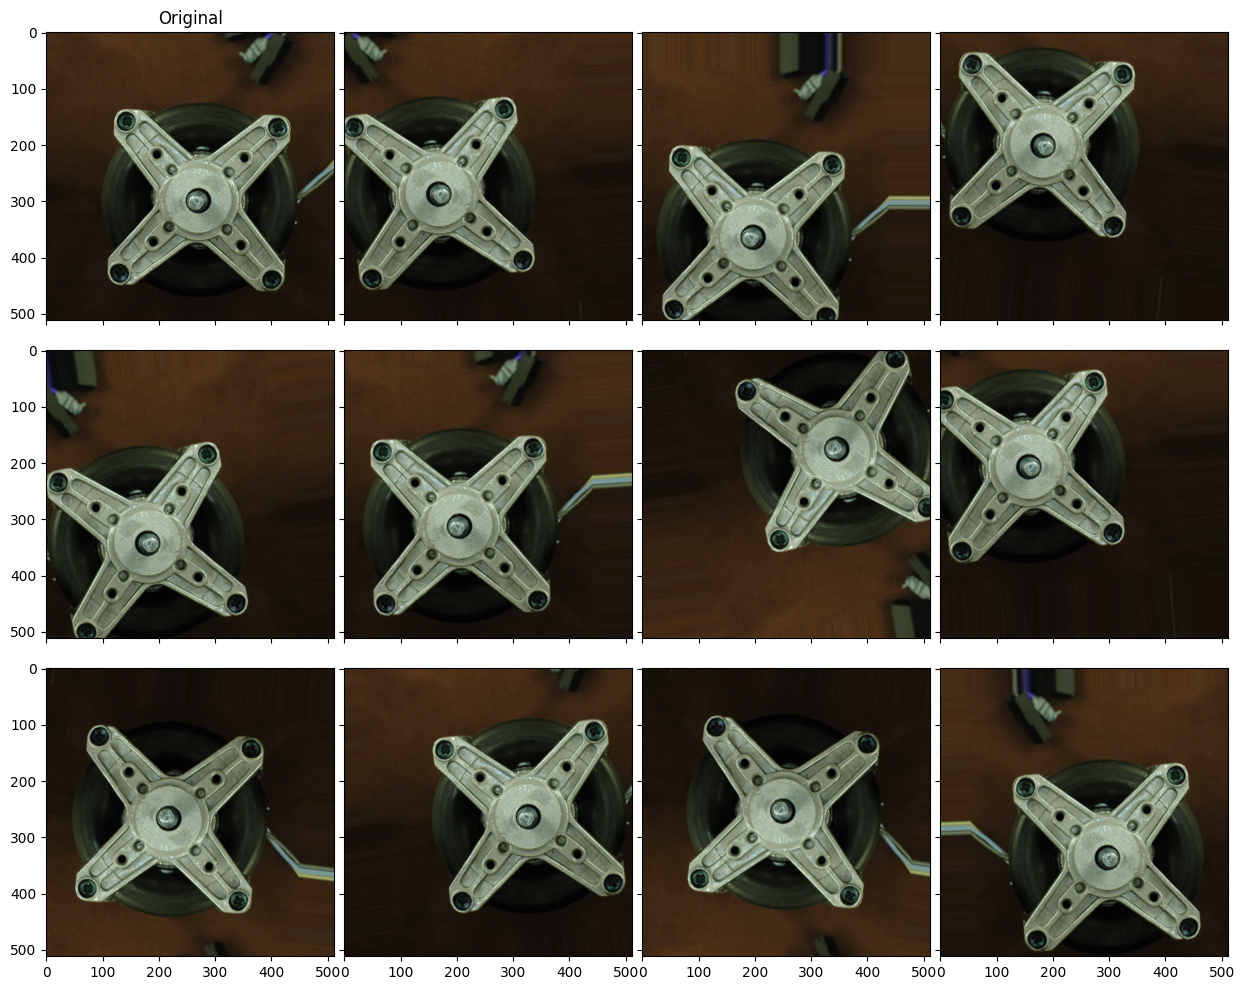

In [110]:
# Display the random augmentations
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=(0.1, 0.3))

grid[0].imshow(features[random_index])
grid[0].set_title("Original")
for i, ax in enumerate(grid[1:]):
    image = datagen.flow(features[[random_index]]).next()[0].astype(int)
    ax.imshow(image) # Plot image
plt.show()

In [113]:
### Run model training with given data generator
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=0.9, stratify=y_train, random_state=21)

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(np.array(X_train))

model = Sequential()
model.add(layers.Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(8, 5, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(16, 5, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(y_train[0].shape[0], activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model.fit(datagen.flow(np.array(X_train), np.array(y_train), batch_size=8), validation_data=(X_validation, y_validation),
          steps_per_epoch=int(len(X_train) / 8), epochs=50)

c:\Users\badar\miniconda3\envs\experiences\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\badar\miniconda3\envs\experiences\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.7091 - loss: 15.0468 - val_accuracy: 0.5000 - val_loss: 8.3590
Epoch 2/50
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5000 - loss: 8.2862

c:\Users\badar\miniconda3\envs\experiences\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5000 - loss: 8.2862 - val_accuracy: 0.5000 - val_loss: 4.9374
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4016 - loss: 3.2299 - val_accuracy: 0.2500 - val_loss: 1.9180
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.1250 - loss: 1.6832 - val_accuracy: 0.2500 - val_loss: 1.6249
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1238 - loss: 1.6797 - val_accuracy: 0.0000e+00 - val_loss: 1.2454
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.3750 - loss: 1.2793 - val_accuracy: 0.2500 - val_loss: 1.2057
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6421 - loss: 0.9929 - val_accuracy: 0.5000 - val_loss: 1.1998
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5000 - loss: 1.2496 - val_accuracy: 0.5000 - val_loss: 1.1569
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 919ms/step - accuracy: 0.6048 - loss: 1.1099 - val_accuracy: 0.5000 - val_loss: 0.9958
Epoch 10/50


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       1.00      0.67      0.80         6
Missing screw       0.76      1.00      0.87        13

     accuracy                           0.81        21
    macro avg       0.59      0.56      0.56        21
 weighted avg       0.76      0.81      0.77        21



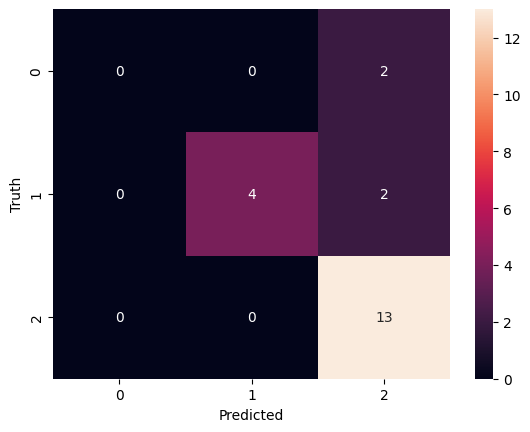

In [114]:
evaluate_model(X_test, y_test, model)

In [116]:
### Changed parameters
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=0.9, stratify=y_train, random_state=21)

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(np.array(X_train))

model = Sequential()
model.add(layers.Conv2D(8, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(8, 5, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(16, 5, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(16, 3, activation = 'relu', padding="same"))
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(y_train[0].shape[0], activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model.fit(datagen.flow(np.array(X_train), np.array(y_train), batch_size=8), validation_data=(X_validation, y_validation),
          steps_per_epoch=int(len(X_train) / 8), epochs=50)

c:\Users\badar\miniconda3\envs\experiences\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\badar\miniconda3\envs\experiences\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.1785 - loss: 6.9029 - val_accuracy: 0.5000 - val_loss: 3.8179
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7500 - loss: 2.1154 - val_accuracy: 0.5000 - val_loss: 3.3875
Epoch 3/50


c:\Users\badar\miniconda3\envs\experiences\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7213 - loss: 1.3179 - val_accuracy: 0.5000 - val_loss: 2.3291
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.6250 - loss: 1.1942 - val_accuracy: 0.5000 - val_loss: 2.0973
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6344 - loss: 0.8921 - val_accuracy: 0.5000 - val_loss: 1.6438
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.7500 - loss: 0.6911 - val_accuracy: 0.5000 - val_loss: 1.5842
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5156 - loss: 0.9151 - val_accuracy: 0.0000e+00 - val_loss: 1.4575
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.3333 - loss: 0.8241 - val_accuracy: 0.0000e+00 - val_loss: 1.3921
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6354 - loss: 0.8232 - val_accuracy: 0.5000 - val_loss: 1.5163
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.3333 - loss: 1.6811 - val_accuracy: 0.5000 - val_loss: 1.3535
Epoch 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
               precision    recall  f1-score   support

     Complete       0.00      0.00      0.00         2
Missing cover       0.60      0.50      0.55         6
Missing screw       0.75      0.92      0.83        13

     accuracy                           0.71        21
    macro avg       0.45      0.47      0.46        21
 weighted avg       0.64      0.71      0.67        21



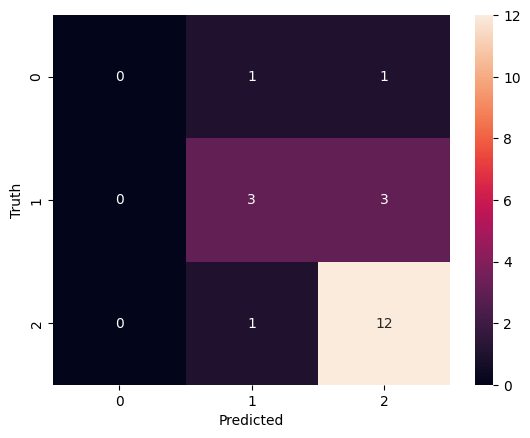

In [117]:
evaluate_model(X_test, y_test, model)

c:\Users\badar\miniconda3\envs\experiences\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.3670 - loss: 1.0934 - val_accuracy: 0.3333 - val_loss: 1.0522
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.6087 - loss: 1.1846 - val_accuracy: 0.3333 - val_loss: 0.9037
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.2422 - loss: 0.7012 - val_accuracy: 0.3333 - val_loss: 0.9006
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.4640 - loss: 0.8161 - val_accuracy: 0.3333 - val_loss: 0.8783
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.4873 - loss: 0.6956 - val_accuracy: 0.3333 - val_loss: 0.8732
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5042 - loss: 0.5321 - val_accuracy: 0.3333 - val_loss: 0.8380
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.3659 - loss: 0.5061 - val_accuracy: 0.3333 - val_loss: 0.7805
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.6146 - loss: 0.3579 - val_accuracy: 0.3333 - 

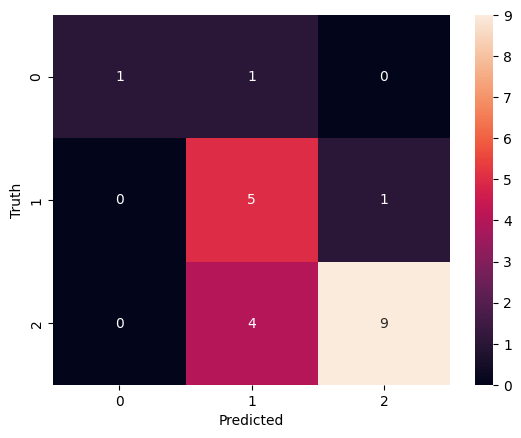

In [119]:
# Data preprocessing
features, labels = load_features_labels("./E_motor/top", size=(512,512), color=True, flatten=False, identifiers=['MC', 'MS', 'C', 'NS'])
features = np.array(features)
labels = np.array(labels)

# Model definition
model = Sequential()
model.add(layers.Conv2D(4, 5,  input_shape = X_train[0].shape, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(8, 3, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(8, 3, activation = 'relu', padding="same"))
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(8, activation = 'relu'))
model.add(layers.Dense(y_train[0].shape[0], activation = 'softmax'))

# Model compilation
optimizer=optimizers.Adam(learning_rate=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

# Model training
model.fit(np.array(X_train), np.array(y_train), epochs = 50, batch_size = 2, validation_split=0.1,
          verbose = 1, sample_weight=compute_sample_weight('balanced', y_train))

# Model evaluation
evaluate_model(X_test, y_test, model)